In [ ]:
import os
import os.path
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn
import torch.nn as nn
from torch import linalg as LA
from torch import optim
import torch.nn.functional as F
from torch.autograd import grad as torch_grad
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import pickle
import shutil
from torchvision.utils import make_grid
import imageio
from google.colab import drive
drive.mount('/content/drive')
from matplotlib import cm


Mounted at /content/drive


# Model (Generator)

## Encoder

In [ ]:
class ConvNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 2, stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(64,momentum=0.9),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size = 3, stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(128,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(128, 256, kernel_size = 2, stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(256,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(256, 256, kernel_size = 2, stride = 1),
        nn.ReLU(),
        nn.BatchNorm2d(256,momentum=0.9),
        nn.MaxPool2d(3),

        nn.Conv2d(256, 512, kernel_size = 3, stride = 1),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
  
  def forward(self, x):
    cnn_val = self.network(x)
    return_val = F.max_pool2d(cnn_val, kernel_size=cnn_val.size()[2:])
    return_val = torch.squeeze(return_val)
    return return_val

In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.convNN = ConvNN()
    self.lstm = nn.LSTM(input_size = 512, hidden_size = 512,
                        batch_first = True, bidirectional = True,
                        num_layers = 4, dropout = 0.2)

  def forward(self, input):
    batch_size = int(input.shape[0]/img_length)
    
    
    in_features = self.convNN(input)
    in_features = torch.reshape(in_features,(batch_size, img_length, 512))
    output, (h_n, c_n) = self.lstm(in_features)
    return h_n[-1]

## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 512, out_channels = 256, 
                               kernel_size = 4, stride = 1, padding = 0, 
                               bias=False), 
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 128, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), 
            nn.Sigmoid()

        )
    def forward(self, input):
      return self.main(input)

# Discriminator (Critic)

In [ ]:


class Discriminator(nn.Module):
  def __init__(self, img_size, dim):

      super(Discriminator, self).__init__()

      self.img_size = img_size

      self.image_to_features = nn.Sequential(
          nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(dim, 2 * dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
          nn.LeakyReLU(0.2),
          nn.Conv2d(8 * dim, self.img_size[2], 4, 2, 1),
          nn.Sigmoid()
      )

      self.features_to_prob = nn.Sequential(
          nn.Linear(192, 1),
          nn.Sigmoid()
      )

  def forward(self, input_data):
    batch_size = input_data.size()[0]
    n_channels = input_data.size()[1]
    x = self.image_to_features(input_data)
    x = x.view(batch_size, -1)
    return self.features_to_prob(x)


# Models

In [ ]:
class CLSTM(nn.Module):
  def __init__(self, latent_dim):
    super(CLSTM, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.latent_dim = latent_dim
  def forward(self, x):
    y_hidden = self.encoder(x) 
    y_hidden = torch.unsqueeze(y_hidden,2)
    y_hidden = torch.unsqueeze(y_hidden,3)
    y_predict = self.decoder(y_hidden)
    return y_predict
  def sample_latent(self, num_samples):
    return torch.randn((num_samples, self.latent_dim))

# Train

In [ ]:
# reference: https://github.com/EmilienDupont/wgan-gp
class Trainer():
  def __init__(self, clstm, discriminator, gen_optimizer, dis_optimizer, train_losses,
               val_losses, criterion, valid_min, checkpoint_path, best_model_path,
              gp_weight=10, critic_iterations=1, print_every=10, 
               use_cuda=True):
    self.G = clstm
    self.G_opt = gen_optimizer
    self.D = discriminator
    self.D_opt = dis_optimizer
    self.train_losses = train_losses
    self.val_losses = val_losses
    self.criterion = criterion
    self.num_steps = 0
    self.use_cuda = use_cuda
    
    self.valid_mse_min = valid_min
    self.checkpoint_path = checkpoint_path
    self.best_model_path = best_model_path

    self.gp_weight = gp_weight
    self.critic_iterations = critic_iterations
    self.print_every = print_every

    self.temp_train_mse = []
    self.temp_val_mse = []

    if self.use_cuda:
        self.G = self.G.cuda()
        self.D = self.D.cuda()
        
        
  def _critic_train_iteration(self, y_pred, y_true, train):
    # Get generated data
    batch_size = y_true.size()[0]  

    # Calculate probabilities on real and generated data
    d_real = self.D(y_true)
    d_generated = self.D(y_pred)


    # Create total loss and optimize
    if train:
      # Get gradient penalty
      gradient_penalty = self._gradient_penalty(y_true, y_pred, train)

      self.D_opt.zero_grad()
      d_real = d_real.view(batch_size, -1)
      d_generated = d_generated.view(batch_size,-1)

      d_loss = torch.mean(d_generated) - torch.mean(d_real) + gradient_penalty

      d_loss.backward(retain_graph = True)
      self.D_opt.step()
     
      self.train_losses['D'].append(d_loss.data.cpu().numpy())
    else:
      d_real = d_real.view(batch_size, -1)
      d_generated = d_generated.view(batch_size,-1)
      d_loss = torch.mean(d_generated) - torch.mean(d_real)
      self.val_losses['val_D'].append(d_loss.data.cpu().numpy())
    

  def _gradient_penalty(self, real_data, generated_data, train):

    batch_size = real_data.size()[0]
    n_channels = real_data.size()[1]

    # Calculate interpolation
    epsilon = torch.rand(batch_size, 1, 1, 1)
    epsilon = epsilon.expand_as(real_data) # make alpha the same length as real_data

    if self.use_cuda:
        epsilon = epsilon.cuda()
    interpolated = epsilon * real_data.data + (1 - epsilon) * generated_data.data # this is x_hat
    if train:    
      interpolated = interpolated.clone().detach().requires_grad_(True)
    if self.use_cuda:
        interpolated = interpolated.cuda()

    # Calculate probability of interpolated examples
    prob_interpolated = self.D(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                            grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
                            prob_interpolated.size()),
                            create_graph=True, retain_graph=True)[0]

    grad_norm = LA.norm(gradients)+1e-12
    if train:
      self.train_losses['gradient_norm'].append(LA.norm(gradients).mean().item())

    # Return gradient penalty
    return self.gp_weight * ((grad_norm - 1) ** 2)
  def _generator_train_iteration(self, y_pred, y_true, train):
    if train:
      self.G_opt.zero_grad()

      # Get generated data
      batch_size = y_true.size()[0]
 
      # Calculate loss and optimize
      d_generated = self.D(y_pred)
      g_loss = - d_generated.mean()
      g_loss.backward()
      self.G_opt.step()

      # Record loss
      g_loss = g_loss.data.cpu().numpy()
      self.train_losses['G'].append(g_loss)
    else:
      # Get generated data
      batch_size = y_true.size()[0]
 
      # Calculate loss and optimize
      d_generated = self.D(y_pred)
      g_loss = - d_generated.mean()

      # Record loss
      g_loss = g_loss.data.cpu().numpy()
      self.val_losses['val_G'].append(g_loss)
  def _train_epoch(self,train_loader):
    for i, batch_train in enumerate(train_loader):
      self.num_steps +=1
      x_train = batch_train[:,:-1,:,:,:]
      y_train = batch_train[:,-1,:,:,:]
      if self.use_cuda:
        x_train, y_train = x_train.cuda(), y_train.cuda()

      n_series = x_train.shape[0]
      n_img_in_series = x_train.shape[1]    
      img_channels = x_train.shape[2]
      img_height = x_train.shape[3]
      img_width = x_train.shape[4]

      x_train_new_dim = (n_series*n_img_in_series, img_channels, img_height, img_width)
      x_train = torch.reshape(x_train,x_train_new_dim)  
      y_train_predict = self.G(x_train)
      y_train_crop = fn.center_crop(y_train, output_size=[256])
      y_train_predict_crop = fn.center_crop(y_train_predict, output_size = [256])
      pixel_diff = self.criterion(y_train_crop, y_train_predict_crop).cpu().detach().numpy()
      self.temp_train_mse.append(pixel_diff)

      self._critic_train_iteration(y_train_predict_crop, y_train_crop, train = True)
      if self.num_steps % self.critic_iterations == 0:
        self._generator_train_iteration(y_train_predict_crop, y_train_crop, train = True)
  def _validate(self, val_loader):
    self.G.eval()
    with torch.no_grad():
      for batch_val in val_loader:
        x_val = batch_val[:,:-1,:,:,:]
        y_val = batch_val[:,-1,:,:,:]
        if self.use_cuda:
          x_val, y_val = x_val.cuda(), y_val.cuda()


        n_series_val = x_val.shape[0]
        n_img_in_series_val = x_val.shape[1]    
        img_channels_val = x_val.shape[2]
        img_height_val = x_val.shape[3]
        img_width_val = x_val.shape[4]

        x_val_new_dim = (n_series_val*n_img_in_series_val, img_channels_val, img_height_val, img_width_val)
        x_val = torch.reshape(x_val,x_val_new_dim)

        y_val_predict = self.G(x_val)
        y_val_crop = fn.center_crop(y_val, output_size=[256])
        y_val_predict_crop = fn.center_crop(y_val_predict, output_size = [256])
        pixel_diff = self.criterion(y_val_crop, y_val_predict_crop).cpu().detach().numpy()
        self.temp_val_mse.append(pixel_diff)
        self._critic_train_iteration(y_val_predict_crop, y_val_crop, train = False)
        self._generator_train_iteration(y_val_predict_crop, y_val_crop, train = False)

  def train(self, train_loader, start_epochs, n_epochs, validate_loader):
    for epoch in range(start_epochs, n_epochs):
      self.G.train()
      self._train_epoch(train_loader)
      self._validate(validate_loader)
      avg_train_mse = sum(self.temp_train_mse)/len(self.temp_train_mse)
      avg_val_mse = sum(self.temp_val_mse)/len(self.temp_val_mse)
      self.train_losses['train_mse'].append(avg_train_mse)
      self.val_losses['val_mse'].append(avg_val_mse)

      if epoch % self.print_every == 0:
        print("Iteration {}".format(epoch + 1))
        print("D: {}".format(self.train_losses['D'][-1]))
        print("val_D: {}".format(self.val_losses['val_D'][-1]))
        print("train_mse:{}".format(self.train_losses['train_mse'][-1]))
        if self.num_steps > self.critic_iterations:
            print("G: {}".format(self.train_losses['G'][-1]))
            print("val_G: {}".format(self.val_losses['val_G'][-1]))
            print("val_mse:{}".format(self.val_losses['val_mse'][-1]))

      ##############
      # checkpoint #
      ##############
      curr_val_mse = self.val_losses['val_mse'][-1]
      if curr_val_mse <= self.valid_mse_min:
        new_valid_mse_min = curr_val_mse
      else:
        new_valid_mse_min = self.valid_mse_min
      if self.use_cuda:
        self.G, self.D = self.G.cpu(), self.D.cpu()
      checkpoint = {
        'epoch': epoch + 1,
        'train_loss': self.train_losses,
        'val_loss': self.val_losses,
        'generator_state_dict': self.G.state_dict(),
        'generator_optimizer': self.G_opt.state_dict(),
        'discriminator_state_dict': self.D.state_dict(),
        'discriminator_optimizer': self.D_opt.state_dict(),
        'lowest_val_loss': new_valid_mse_min
        }
      # save checkpoint
      save_ckp(checkpoint, False, self.checkpoint_path, self.best_model_path)

      
      # save the model if validation loss has decreased
      if curr_val_mse <= self.valid_mse_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(self.valid_mse_min,curr_val_mse))
          # save checkpoint as best model
          save_ckp(checkpoint, True, self.checkpoint_path, self.best_model_path)
          self.valid_mse_min = curr_val_mse

      self.temp_train_mse = []
      self.temp_val_mse = []
      if self.use_cuda:
        self.G, self.D = self.G.cuda(), self.D.cuda()



# Checkpoint

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
  f_path = checkpoint_path
  torch.save(state, f_path)
  if is_best:
      print("Saving a new best model")
      best_fpath = best_model_path
      # copy that checkpoint file to best path given, best_model_path
      shutil.copyfile(f_path, best_fpath)
  else:
    print('Validation does not improve')

In [ ]:
def load_ckp(checkpoint_fpath, gen_model, gen_opt, discrim_model, discrim_opt):
    
    device = torch.device("cuda")
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    gen_model.load_state_dict(checkpoint['generator_state_dict'])
    discrim_model.load_state_dict(checkpoint['discriminator_state_dict'])
    gen_model = gen_model.to(device)
    discrim_model = discrim_model.to(device)
    # initialize optimizer from checkpoint to optimizer
    gen_opt.load_state_dict(checkpoint['generator_optimizer'])
    discrim_opt.load_state_dict(checkpoint['discriminator_optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    train_loss_lst = checkpoint['train_loss']
    valid_loss_lst = checkpoint['val_loss']
    print(valid_loss_lst)
    lowest_val_loss = checkpoint['lowest_val_loss']

    return checkpoint['epoch'], gen_model, discrim_model, gen_opt, discrim_opt, train_loss_lst,valid_loss_lst, lowest_val_loss


# Setting Parameters

# Loading Datapoint

In [ ]:
# convert the image to array 
x_img_length = 2

x_arr = np.zeros(shape=(100,x_img_length, 3,288,432), dtype=np.uint8)
y_arr = np.zeros(shape=(100,1,3,288,432), dtype=np.uint8)



for i in range(100): # loop through 100 series
  for j in range(x_img_length): # loop through images within series
    model_path = "/content/drive/MyDrive/Capstone/Capstone_data_jpg/"+str(i)
    x_to_convert = Image.open(model_path+'/'+"{:02d}".format(j)+'im.jpg')
    x = np.asarray(x_to_convert)
    x = np.moveaxis(x,-1,0) # change image dimension to channel first
    x_arr[i][j] = x
  y_to_convert = Image.open(model_path+'/'+"{:02d}".format(x_img_length+1)+'im.jpg')
  y = np.asarray(y_to_convert)
  y = np.moveaxis(y,-1,0) # change image dimension to channel first
  y_arr[i][0] = y

# image dimention
n_series = x_arr.shape[0]
n_img_in_series = x_arr.shape[1]
img_channels = x_arr.shape[2]
img_height = x_arr.shape[3]
img_width = x_arr.shape[4]

# train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size = 0.2, random_state = 1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1)

num_train_data = X_train.shape[0]
num_val_data = X_val.shape[0]
num_test_data = X_test.shape[0]

# generating means and std for normalization
trans_X_train= torch.tensor((np.array(X_train)/255).astype(np.float32))
trans_y_train = torch.tensor((np.array(y_train)/255).astype(np.float32))
trans_X_val = torch.tensor((np.array(X_val)/255).astype(np.float32))
trans_y_val = torch.tensor((np.array(y_val)/255).astype(np.float32))
trans_X_test = torch.tensor((np.array(X_test)/255).astype(np.float32))
trans_y_test = torch.tensor((np.array(y_test)/255).astype(np.float32))


# final train/val/test data 
final_train_data = torch.cat((trans_X_train, trans_y_train), dim = 1)
final_val_data = torch.cat((trans_X_val,trans_y_val),dim = 1)
final_test_data = torch.cat((trans_X_test,trans_y_test),dim = 1)

In [ ]:
batch_train_num = 8
batch_valid_num = 10
batch_test_num= 10

train_dl = DataLoader(final_train_data, batch_train_num, shuffle = True)
val_dl = DataLoader(final_val_data, batch_valid_num, shuffle = True)
test_dl = DataLoader(final_test_data, batch_test_num, shuffle = False)

# Calling Train

In [ ]:
# Train model

# setting parameters
x_img_length = 2
img_length = x_img_length
clstm = CLSTM(512)
img_size = (288, 432, 3)
discriminator = Discriminator(img_size=img_size, dim=16)
criterion = nn.MSELoss()
print(clstm)
print(discriminator)

# Initialize optimizers
lr = 0.00001
betas = (.9, .99)
g_optimizer = optim.RMSprop(clstm.parameters(), lr = lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr = lr)
use_cuda = torch.cuda.is_available()


start_epochs = 0
n_epochs = 5

valid_loss_min_input = np.Inf
train_losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': [], "train_mse" :[]}
val_losses = {'val_G': [], 'val_D': [], "val_mse":[]}

checkpoint_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/clstm_wasser_upsample_opti_1000_final_2.pt"
best_model_path = "/content/drive/MyDrive/Capstone/Capstone_models/clstm_wasser_upsample_opti_best_final_2.pt"

trainer = Trainer(clstm, discriminator, g_optimizer, d_optimizer,train_losses,val_losses,criterion,
                  valid_loss_min_input, checkpoint_path, best_model_path,
                  gp_weight = 10, use_cuda=torch.cuda.is_available())


CLSTM(
  (encoder): Encoder(
    (convNN): ConvNN(
      (network): Sequential(
        (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
        (9): ReLU()
        (10): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (12): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1))
        (13): ReLU()
        (14): BatchNorm2d(256, eps=

In [ ]:
# trainer.train(train_dl, start_epochs,  n_epochs, val_dl)

Iteration 1
D: 9.975245475769043
val_D: -4.017353057861328e-05
train_mse:0.189521361887455
G: -0.5741768479347229
val_G: -0.5677058100700378
val_mse:0.11293256282806396
Validation does not improve
Validation loss decreased (inf --> 0.112933).  Saving model ...
Saving a new best model
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve


In [ ]:
# loading checkpoint if model fail
# ckp_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/clstm_wasser_upsample_opti_1000_final.pt"
ckp_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/clstm_wasser_upsample_opti_1000_final_2.pt"

clstm = CLSTM(512)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda")

img_size = (288, 432, 3)
discriminator = Discriminator(img_size=img_size, dim=16)

# Initialize optimizers
lr = 0.00001
betas = (.9, .99)
g_optimizer = optim.RMSprop(clstm.parameters(), lr = lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr = lr)
use_cuda = torch.cuda.is_available()

batch_train_num = 8
batch_valid_num = 10
batch_test_num= 10

img_length = 2

start_epoch, g_model, d_model, g_opt, d_opt, train_losses, valid_losses, lowest_val_loss = load_ckp(ckp_path, clstm, g_optimizer,discriminator,d_optimizer)
print(g_model)


{'val_G': [array(-0.5677058, dtype=float32), array(-0.56679225, dtype=float32), array(-0.56585723, dtype=float32), array(-0.5649588, dtype=float32), array(-0.5642179, dtype=float32), array(-0.5641148, dtype=float32), array(-0.56479704, dtype=float32), array(-0.5662947, dtype=float32), array(-0.56859183, dtype=float32), array(-0.5709512, dtype=float32), array(-0.57240385, dtype=float32), array(-0.57290155, dtype=float32), array(-0.57298523, dtype=float32), array(-0.57292265, dtype=float32), array(-0.57285136, dtype=float32), array(-0.57279354, dtype=float32), array(-0.57273996, dtype=float32), array(-0.5726987, dtype=float32), array(-0.5726652, dtype=float32), array(-0.57263947, dtype=float32), array(-0.5726347, dtype=float32), array(-0.5726411, dtype=float32), array(-0.57266617, dtype=float32), array(-0.5727444, dtype=float32), array(-0.57286733, dtype=float32), array(-0.5730422, dtype=float32), array(-0.573248, dtype=float32), array(-0.5734467, dtype=float32), array(-0.5736427, dtype=

In [ ]:
# continue training 

n_epochs = 1000
checkpoint_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/clstm_wasser_upsample_opti_1000_final_2.pt"
best_model_path = "/content/drive/MyDrive/Capstone/Capstone_models/clstm_wasser_upsample_opti_best_final_2.pt"
use_cuda = torch.cuda.is_available()


trainer = Trainer(clstm, discriminator, g_optimizer, d_optimizer,train_losses,val_losses,criterion,
                  lowest_val_loss, checkpoint_path, best_model_path,
                  gp_weight = 0.1, use_cuda=torch.cuda.is_available())



In [ ]:
# trainer.train(train_dl, start_epoch,  n_epochs, val_dl)

Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Iteration 11
D: 0.1080101802945137
val_D: 0.0069956183433532715
train_mse:0.24165983945131303
G: -0.5734254717826843
val_G: -0.5724038481712341
val_mse:0.22188349068164825
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Iteration 21
D: 0.10391920804977417
val_D: 0.0040070414543151855
train_mse:0.2550769507884979
G: -0.5725773572921753
val_G: -0.5726346969604492
val_mse:0.2515849769115448
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation does not improve
Validation do

# Result

In [ ]:
print(len(val_losses['val_mse']))

0


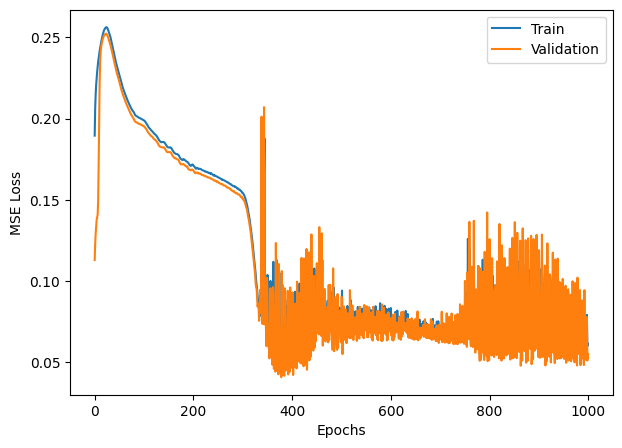

In [ ]:

plt.subplots(figsize=(7, 5))
plt.plot(train_losses['train_mse'], label = "Train")
plt.plot(valid_losses['val_mse'], label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/Capstone/Capstone Meeting/4_best_fina_Epochs_clstm.png")
plt.show()



#Testing

In [ ]:
def test(model, test_loader):    
  model.eval()
  with torch.no_grad():
    for batch_test in test_loader:
      x_test = batch_test[:,:-1,:,:,:]
      y_test = batch_test[:,-1,:,:,:]
      if use_cuda:
        x_test, y_test, model = x_test.cuda(), y_test.cuda(), model.cuda()


      n_series_test = x_test.shape[0]
      n_img_in_series_test = x_test.shape[1]    
      img_channels_test = x_test.shape[2]
      img_height_test = x_test.shape[3]
      img_width_test = x_test.shape[4]

      x_test_new_dim = (n_series_test*n_img_in_series_test, img_channels_test, img_height_test, img_width_test)
      x_test = torch.reshape(x_test,x_test_new_dim)

      y_test_predict = model(x_test)
      
      y_test_crop = fn.center_crop(y_test, output_size=[256])
      pred_img_out = fn.center_crop(y_test_predict,output_size = [256])

      real_img_out = y_test_crop*255
      pred_img_out = pred_img_out*255
      
      real_img_out = real_img_out.cpu().numpy()
      pred_img_out = pred_img_out.cpu().numpy()

      real_img_out = np.moveaxis(real_img_out,1,3)
      pred_img_out = np.moveaxis(pred_img_out, 1,3)

      real_img_out = np.uint8(real_img_out)
      pred_img_out = np.uint8(pred_img_out)
      for img_num in range(real_img_out.shape[0]):

        real_out = real_img_out[img_num]
        pred_out = pred_img_out[img_num]
      
        real_out = Image.fromarray(real_out)
        pred_out = Image.fromarray(pred_out)

        real_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/wasser"+'/'+"{:02d}".format(img_num)+'_real.jpg')
        pred_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/wasser"+'/'+"{:02d}".format(img_num)+'_pred.jpg')


  return y_test_predict, y_test_crop

In [ ]:
def test_more(model):
  model.eval()
  with torch.no_grad():
    x_arr = np.zeros(shape=(10,2,3,288,432))
    y_arr = np.zeros(shape = (10,3,288,432))
    index = 0 
    for series in range(100,110): # loop through 100 series
      for input in range(2): # loop through images within series
        model_path = "/content/drive/MyDrive/Capstone/Capstone_data_jpg/"+str(series)
        x_to_convert = Image.open(model_path+'/'+"{:02d}".format(input)+'im.jpg')
        x = np.asarray(x_to_convert)
        x = np.moveaxis(x,-1,0) # change image dimension to channel first
        x_arr[index][input] = x
      y_to_convert = Image.open(model_path+'/'+"{:02d}".format(2)+'im.jpg')
      y = np.asarray(y_to_convert)
      y = np.moveaxis(y,-1,0) # change image dimension to channel first
      y_arr[index] = y
      index+=1
    x_arr = (np.array(x_arr)/255).astype(np.float32)
    y_arr = (np.array(y_arr)/255).astype(np.float32)
    x_tor = torch.tensor(x_arr)
    y_tor = torch.tensor(y_arr)
    if use_cuda:
      x_test, y_test, model = x_tor.cuda(), y_tor.cuda(), model.cuda()


    n_series_test = x_test.shape[0]
    n_img_in_series_test = x_test.shape[1]    
    img_channels_test = x_test.shape[2]
    img_height_test = x_test.shape[3]
    img_width_test = x_test.shape[4]

    x_test_new_dim = (n_series_test*n_img_in_series_test, img_channels_test, img_height_test, img_width_test)

    x_test = torch.reshape(x_test,x_test_new_dim)

    y_test_predict = model(x_test)
    y_test_crop = fn.center_crop(y_test, output_size=[256])
    y_test_predict = fn.center_crop(y_test_predict, output_size = [256])


    real_img_out = y_test_crop*255
    pred_img_out = y_test_predict*255
    
    real_img_out = real_img_out.cpu().numpy()
    pred_img_out = pred_img_out.cpu().numpy()

    real_img_out = np.moveaxis(real_img_out,1,3)
    pred_img_out = np.moveaxis(pred_img_out, 1,3)

    real_img_out = np.uint8(real_img_out)
    pred_img_out = np.uint8(pred_img_out)
    for img_num in range(real_img_out.shape[0]):

      real_out = real_img_out[img_num]
      pred_out = pred_img_out[img_num]
    
      real_out = Image.fromarray(real_out)
      pred_out = Image.fromarray(pred_out)

      real_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/wasser"+'/'+"{:02d}".format(img_num+10)+'_real.jpg')
      pred_out.save("/content/drive/MyDrive/Capstone/Capstone_model_generated_imgs/mse_wasser_lsgan/wasser"+'/'+"{:02d}".format(img_num+10)+'_pred.jpg')


In [ ]:
img_length = x_img_length
use_cuda = torch.cuda.is_available()
best_model_path = "/content/drive/MyDrive/Capstone/Capstone_checkpoint_models/clstm_wasser_upsample_opti_1000_final_2.pt"
clstm_trained = CLSTM(512)
best_condi = torch.load(best_model_path)
clstm_trained.load_state_dict(best_condi['generator_state_dict'])



<All keys matched successfully>

In [ ]:
gen_y_test, true_y_test = test(clstm_trained, test_dl)

In [ ]:
test_more(clstm_trained)

In [ ]:
print(gen_y_test[0,0,200,:])
gen_y_test_new = (gen_y_test)*255

gen_y_test_new = fn.center_crop(gen_y_test_new, output_size = [256])
print(gen_y_test_new[0,0,200,:])

tensor([0.2651, 0.4037, 0.1715,  ..., 0.5262, 0.5212, 0.4736], device='cuda:0')
tensor([255.0000, 254.0978, 255.0000, 254.9982, 255.0000, 255.0000, 255.0000,
        254.9798, 255.0000, 230.5574, 255.0000, 254.8848, 255.0000, 254.9988,
        255.0000, 254.9566, 254.9999, 192.3174, 254.8888, 244.9205, 254.7000,
        254.9947, 254.9988, 243.4395, 254.9751,  32.0313, 107.4843, 220.9176,
         67.2765,  77.1660,  32.8154,  36.0243,  51.7421, 118.7635, 114.4665,
        172.5090, 147.1332,  88.2486,  57.9675, 105.5105,  60.6820, 111.9486,
         58.2899,  96.3774,  42.6132, 100.1036,  48.7501,  58.5981,  69.7643,
         41.7617,  87.8461, 103.0846,  58.1162,  82.5756,  73.2672,  45.3436,
        128.4761,  65.8419, 112.6617,  77.3601,  54.0077,  46.5551,  49.1331,
         44.7036, 109.1643,  64.5139,  91.8193,  39.2663,  36.1217,  20.7297,
         41.3472,  24.0049,  59.4611,  45.2591,  60.3221,  84.4241,  83.2050,
         89.3097,  90.8370,  40.0337,  84.9570,  76.6789,  52.

In [ ]:
gen_y_test_np = gen_y_test_new.cpu().numpy()

print(gen_y_test_np.shape)
gen_y_test_move = np.moveaxis(gen_y_test_np,1,3)
print(gen_y_test_move.shape)
gen_y_test_image = np.uint8(gen_y_test_move)


(10, 3, 256, 256)
(10, 256, 256, 3)


In [ ]:
print(gen_y_test_image[0].shape)
transforms.ToPILImage()(gen_y_test_image[6])

print(gen_y_test_image[6].shape)

(256, 256, 3)
(256, 256, 3)



[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 2

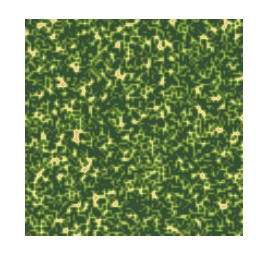

In [ ]:


true_y_test_np = true_y_test.cpu().numpy()
true_y_test_move = np.moveaxis(true_y_test_np,1,3)
new_true_y_test = np.uint8(true_y_test_move *255)
transforms.ToPILImage()(new_true_y_test[7])


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


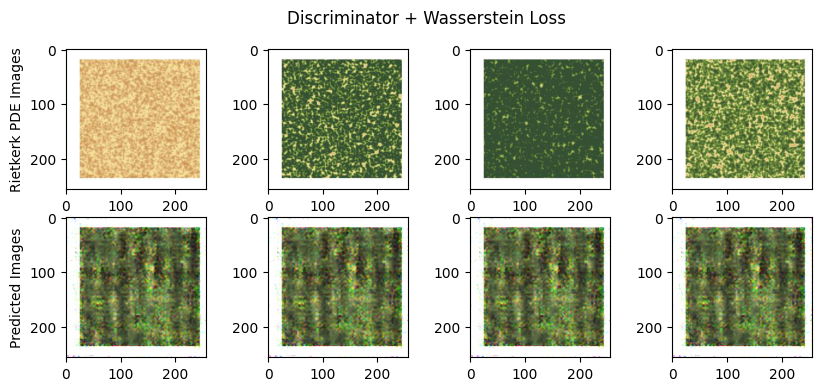

In [ ]:
f, axarr = plt.subplots(2,4,figsize=(10, 4))

img_num = 0
for img_true,img_pred in zip(new_true_y_test[3:7],gen_y_test_image[3:7]):


  print(img_true.shape)
  axarr[0,img_num].imshow(img_true)
  axarr[0,0].set_ylabel("Rietkerk PDE Images")
  axarr[1,img_num].imshow((img_pred).astype(np.uint8))
  axarr[1,0].set_ylabel("Predicted Images")

  img_num +=1

f.suptitle('Discriminator + Wasserstein Loss')
plt.show()


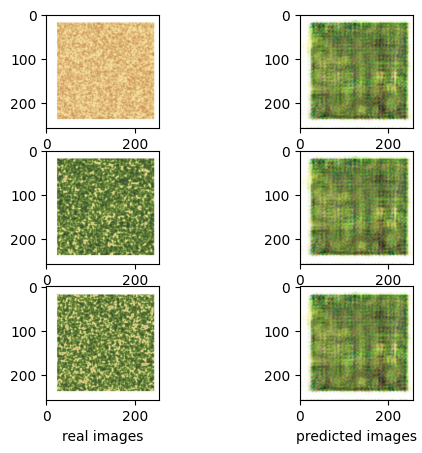

In [ ]:

f, axarr = plt.subplots(10,2,figsize=(6, 5))

img_num = 0
for img_crop,img_pred in zip(new_true_y_test[:3],gen_y_test_image[:3]):

  axarr[img_num,0].imshow((img_crop).astype(np.uint8))
  axarr[img_num,1].imshow((img_pred).astype(np.uint8))

  axarr[2,0].set_xlabel("real images")
  axarr[2,1].set_xlabel("predicted images")
  img_num +=1
plt.show()